In [27]:
import pandas as pd
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import seaborn as sns
import scipy.stats as stats


In [2]:
load_dotenv()
PATH2fold0 = os.getenv("PATH2fold0")

In [4]:
X_gp_df = pd.read_csv(PATH2fold0 + 'emb_train.csv')
Y_pred_df = pd.read_csv(PATH2fold0 + 'uv_pred_train.csv')
Y_true_df = pd.read_csv(PATH2fold0 + 'train_full.csv') 

In [5]:
def scale_spectra(data):
    for i, row in data.iterrows():
        scaled_row = (row.values - np.min(row.values)) / (np.max(row.values) - np.min(row.values))
        data.loc[i] = scaled_row

    return data

In [6]:
X_gp_train = torch.tensor(X_gp_df.iloc[:, 1:].values, dtype=torch.float32)
Y_pred_train = torch.tensor(scale_spectra(Y_pred_df.iloc[:, 1:]).values, dtype=torch.float32)
Y_true_train = torch.tensor(Y_true_df.iloc[:, 1:].values, dtype=torch.float32)

Y_residuals_train = Y_true_train - Y_pred_train

print(f"Размерность эмбеддингов (X_gp_train): {X_gp_train.shape}")
print(f"Размерность предсказанных спектров (Y_pred_train): {Y_pred_train.shape}")
print(f"Размерность истинных спектров (Y_true_train): {Y_true_train.shape}")
print(f"Размерность остатков (Y_residuals_train): {Y_residuals_train.shape}")

Размерность эмбеддингов (X_gp_train): torch.Size([745, 900])
Размерность предсказанных спектров (Y_pred_train): torch.Size([745, 181])
Размерность истинных спектров (Y_true_train): torch.Size([745, 181])
Размерность остатков (Y_residuals_train): torch.Size([745, 181])


## проверка на нормальность

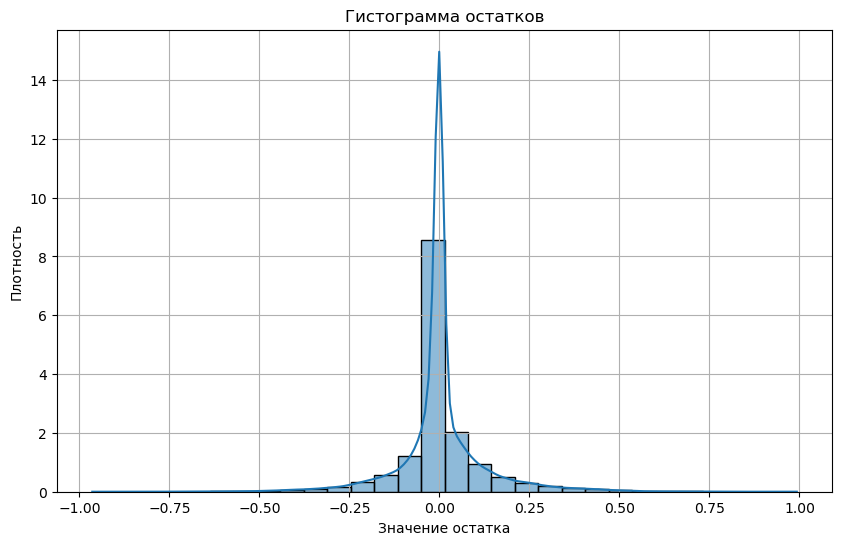

In [26]:
# Выберем одну точку спектра для примера, или все остатки, если их агрегировать
# Для всех остатков сразу (привести к 1D массиву)
all_residuals = Y_residuals_train.flatten().cpu().numpy()

plt.figure(figsize=(10, 6))
sns.histplot(all_residuals, bins=30, kde=True, stat="density")
plt.title('Гистограмма остатков')
plt.xlabel('Значение остатка')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

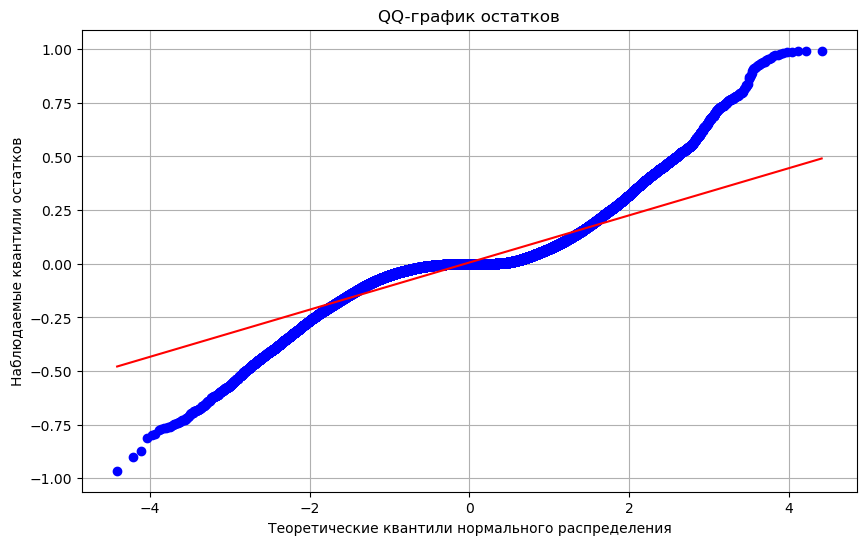

In [28]:
plt.figure(figsize=(10, 6))
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title('QQ-график остатков')
plt.xlabel('Теоретические квантили нормального распределения')
plt.ylabel('Наблюдаемые квантили остатков')
plt.grid(True)
plt.show()

In [29]:
# Применяем к агрегированным остаткам
shapiro_test_statistic, shapiro_p_value = stats.shapiro(all_residuals)
print(f"\nТест Шапиро-Уилка: Статистика={shapiro_test_statistic:.4f}, p-value={shapiro_p_value:.4f}")
if shapiro_p_value > 0.05:
    print("Остатки выглядят нормально распределенными (p > 0.05)")
else:
    print("Остатки не выглядят нормально распределенными (p <= 0.05)")


Тест Шапиро-Уилка: Статистика=0.8178, p-value=0.0000
Остатки не выглядят нормально распределенными (p <= 0.05)


/tmp/ipykernel_23271/3133847959.py:2: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 134845.
  shapiro_test_statistic, shapiro_p_value = stats.shapiro(all_residuals)


In [36]:
print(f"Среднее значение остатков: {np.mean(all_residuals):.4f}")

Среднее значение остатков: 0.0059


In [34]:
mean_residuals = np.mean(all_residuals)
std_residuals = np.std(all_residuals)

kstest_statistic, kstest_p_value = stats.kstest(all_residuals, 'norm', args=(mean_residuals, std_residuals))

print(f"\nТест Колмогорова-Смирнова: Статистика={kstest_statistic:.4f}, p-value={kstest_p_value:.15f}")
if kstest_p_value > 0.05:
    print("Остатки выглядят нормально распределенными (p > 0.05)")
else:
    print("Остатки не выглядят нормально распределенными (p <= 0.05)")


Тест Колмогорова-Смирнова: Статистика=0.1958, p-value=0.000000000000000
Остатки не выглядят нормально распределенными (p <= 0.05)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_gp_train = X_gp_train.to(device)
Y_residuals_train = Y_residuals_train.to(device)
Y_pred_train = Y_pred_train.to(device)

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF'):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            self.cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel == 'Matern':
            self.cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        else:
            raise ValueError("Неподдерживаемое ядро. Используйте 'RBF' или 'Matern'.")

    def forward(self, x):
        mean_x = self.mean_module(x)
        cov_x = self.cov_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x)

In [9]:
# Гиперпараметры для обучения GP
learning_rate = 0.01
training_iterations = 100
kernel_type = 'RBF'

spectrum_len = Y_residuals_train.shape[1]
gp_models = []
gp_likelihoods = []

print(f"\nНачинаем обучение {spectrum_len} независимых GP моделей...")

for i in range(spectrum_len):
    print(f"Обучение GP для точки спектра {i+1}/{spectrum_len}...")

    current_y_residuals = Y_residuals_train[:, i]

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(X_gp_train, current_y_residuals, likelihood, kernel=kernel_type).to(device)

    model.train()
    likelihood.train()


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for iter in range(training_iterations):
        optimizer.zero_grad()
        output = model(X_gp_train)
        loss = -mll(output, current_y_residuals)
        loss.backward()
        # if (iter + 1) % 10 == 0:
        #     print(f"  Точка {i+1}, Итерация {iter+1}/{training_iterations}, Loss: {loss.item():.4f}")
        optimizer.step()

    gp_models.append(model)
    gp_likelihoods.append(likelihood)

print("Обучение всех GP моделей завершено.")


Начинаем обучение 181 независимых GP моделей...
Обучение GP для точки спектра 1/181...
Обучение GP для точки спектра 2/181...
Обучение GP для точки спектра 3/181...
Обучение GP для точки спектра 4/181...
Обучение GP для точки спектра 5/181...
Обучение GP для точки спектра 6/181...
Обучение GP для точки спектра 7/181...
Обучение GP для точки спектра 8/181...
Обучение GP для точки спектра 9/181...
Обучение GP для точки спектра 10/181...
Обучение GP для точки спектра 11/181...
Обучение GP для точки спектра 12/181...
Обучение GP для точки спектра 13/181...
Обучение GP для точки спектра 14/181...
Обучение GP для точки спектра 15/181...
Обучение GP для точки спектра 16/181...
Обучение GP для точки спектра 17/181...
Обучение GP для точки спектра 18/181...
Обучение GP для точки спектра 19/181...
Обучение GP для точки спектра 20/181...
Обучение GP для точки спектра 21/181...
Обучение GP для точки спектра 22/181...
Обучение GP для точки спектра 23/181...
Обучение GP для точки спектра 24/181...


## тест

In [17]:
X_gp_df_test = pd.read_csv(PATH2fold0 + 'emb_test.csv')
Y_pred_df_test = pd.read_csv(PATH2fold0 + 'uv_pred_test.csv')
Y_true_df_test = pd.read_csv(PATH2fold0 + 'test_full.csv')

In [20]:
X_gp_test = torch.tensor(X_gp_df_test.iloc[:, 1:].values, dtype=torch.float32)
Y_pred_test = torch.tensor(scale_spectra(Y_pred_df_test.iloc[:, 1:]).values, dtype=torch.float32)
Y_true_test = torch.tensor(Y_true_df_test.iloc[:, 1:].values, dtype=torch.float32)

In [46]:
# Переводим GP модели в режим оценки
for model in gp_models:
    model.eval()
for likelihood in gp_likelihoods:
    likelihood.eval()

# Сбор предсказаний GP
gp_means = []
gp_variances = []

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in range(spectrum_len):
        model = gp_models[i]
        likelihood = gp_likelihoods[i]

        observed_pred = likelihood(model(X_gp_test))
        mean = observed_pred.mean
        variance = observed_pred.variance
        
        gp_means.append(mean.cpu())
        gp_variances.append(variance.cpu())

# Объединяем результаты
gp_means = torch.stack(gp_means, dim=1) # (num_test_samples, spectrum_len)
#gp_variances = torch.stack(gp_variances, dim=1)
gp_variances = scale_spectra(pd.DataFrame(torch.stack(gp_variances, dim=1).numpy())) # (num_test_samples, spectrum_len)
scaled_gp_variances = torch.tensor(gp_variances.values, dtype=torch.float32).to(device)

# Финальное предсказание спектра с учетом поправок GP
final_spectrum_mean = Y_pred_test.cpu() + gp_means
final_spectrum_std = torch.sqrt(scaled_gp_variances) # Стандартное отклонение = корень из дисперсии

print(f"\nФинальные предсказанные спектры (среднее): {final_spectrum_mean.shape}")
print(f"Оценка стандартного отклонения (неопределенность): {final_spectrum_std.shape}")


Финальные предсказанные спектры (среднее): torch.Size([94, 181])
Оценка стандартного отклонения (неопределенность): torch.Size([94, 181])


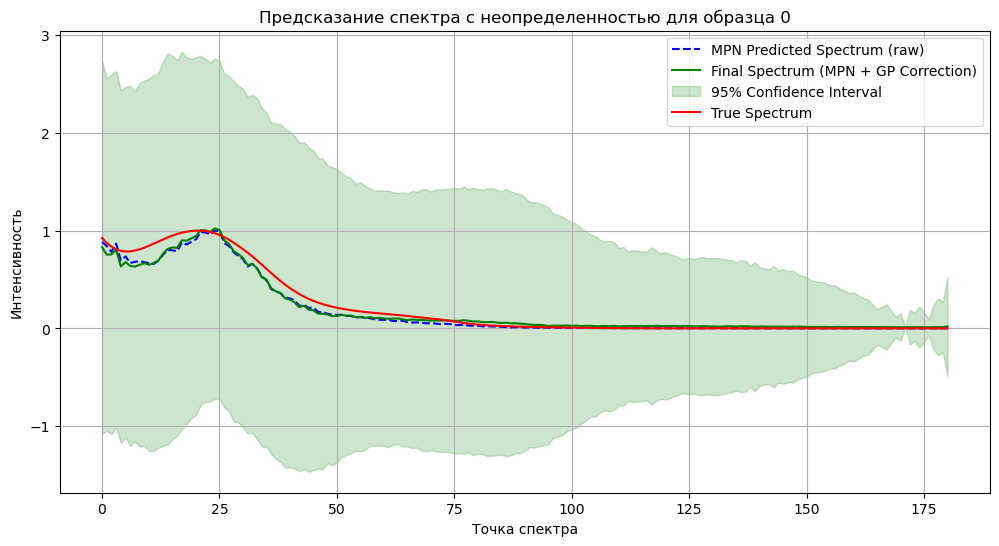

In [22]:
# Визуализация для одной молекулы из тестового набора
sample_idx = 0

plt.figure(figsize=(12, 6))
plt.plot(Y_pred_test[sample_idx].cpu().numpy(), label='MPN Predicted Spectrum (raw)', color='blue', linestyle='--')
plt.plot(final_spectrum_mean[sample_idx].numpy(), label='Final Spectrum (MPN + GP Correction)', color='green')
plt.fill_between(range(spectrum_len),
                 (final_spectrum_mean[sample_idx] - 2 * final_spectrum_std[sample_idx]).numpy(),
                 (final_spectrum_mean[sample_idx] + 2 * final_spectrum_std[sample_idx]).numpy(),
                 alpha=0.2, color='green', label='95% Confidence Interval')
# Если есть истинные значения для тестового набора
plt.plot(Y_true_test[sample_idx].cpu().numpy(), label='True Spectrum', color='red') # Нужно загрузить Y_true_test
plt.title(f'Предсказание спектра с неопределенностью для образца {sample_idx}')
plt.xlabel('Точка спектра')
plt.ylabel('Интенсивность')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
save_dir = 'gp_models_checkpoint'
os.makedirs(PATH2fold0 + save_dir, exist_ok=True)

# gp_models и gp_likelihoods - это списки обученных моделей и их likelihoods из предыдущего шага
for i, (model, likelihood) in enumerate(zip(gp_models, gp_likelihoods)):
    # Создаем словарь для сохранения
    # Сохраняем state_dict модели и likelihood, а также kernel_type (если нужно)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'likelihood_state_dict': likelihood.state_dict(),
        'kernel_type': kernel_type # Сохраняем тип ядра, чтобы восстановить модель с тем же ядром
    }
    #torch.save(checkpoint, os.path.join(PATH2fold0+save_dir, f'gp_model_{i}.pt'))

print(f"Все GP модели сохранены в директории: {save_dir}")

Все GP модели сохранены в директории: gp_models_checkpoint
